In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy

from sklearn.decomposition import PCA
from modules.pca_module import perform_pca
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


### 1-Load data

In [2]:
knn_df = pd.read_csv('clean_data/withsetc/KNN_imputed_df.csv')
m1_df = pd.read_csv('clean_data/withsetc/minus1_imputed_df.csv')

In [92]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
4357,143554.0,64.0,0,3,71.083073,1,10.0,10.0,0.244105,0.7,14.285714,0.35,0.5,14.285714,11.0,9.090909,135.0,106.0,135.0,27.358491,2.386269,30.0,6.666667,31.3,0.638978,74.0,84.0,5.405405,0.114199,4.05,4.2,4.6,4.761905,2.18495,12.563165,1.95,1.9,2.3,10.526316,90.0,115.0,5.555556,88.0,0.046624,139.0,0.0,0.023578,70.67,110.3,8.9642,70.67,0.164163,59.0,64.0,8.474576,-0.053333,82.0,82.0,159.0,30.487805,-2.634253,7.35,0.544218,240.0,1.25,2.061026,36.8,37.2,0.271739,36.9,80.0,275.0,43.75,120.0,0.795293,11.9,7.563025,-0.049445,104.6,0.0,-3.830301e-16,5,0


In [93]:
knn_df.shape , m1_df.shape

((12000, 83), (12000, 83))

Transfor the days of stay in:
 - 0 if stay < 8
 - 1 if stay >= 8 but <31
 - 2 if stay > = 31 

In [94]:
knn_df['Length_of_stay'] = knn_df['Length_of_stay'].apply(lambda x: 0 if x < 8 else( 1 if x <31 else 2))
m1_df['Length_of_stay'] = m1_df['Length_of_stay'].apply(lambda x: 0 if x < 8 else( 1 if x <31 else 2))

### 2-Look at the distribution target("type") variable
As both df are the same and its difference is the NaN imputation, the outcomes distribution will be the same

In [95]:
knn_df['Length_of_stay'].value_counts()

Length_of_stay
1    6859
0    4262
2     879
Name: count, dtype: int64

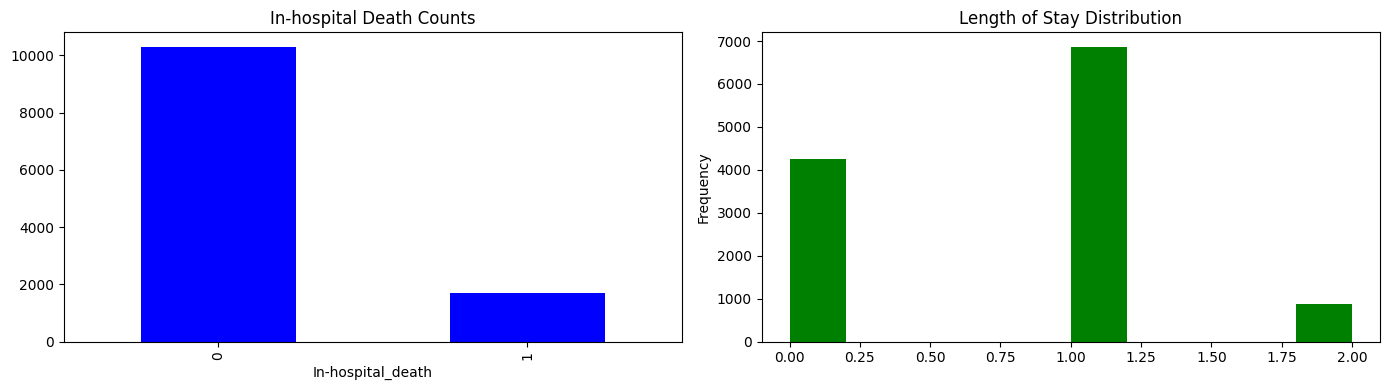

In [96]:
import matplotlib.pyplot as plt

# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()


### 3-LENGTH_OF_STAY PREDICTION

**3.1 -Create a function that**
 - remove the outcome columns and palaces RecordID as index
 - splits the data
 - normalizes the data
 - creates / compiles and trains a basic model
 - predicts the outcomes


*FUNCTION PARAMETERS*
- Input layer - 512 nodes, activation ReLu, input features
- Dropout= 0.2
- Hidden layer - 512 nodes activation ReLu
- Output - 3 node, activation softmax

*Optimization and cost for the model*
- loss - 'categorical_crossentropy'

- optimizer - SGD # Stochastic Gradient Descent

- metrics - "mae" # Mean average error  

In order to keep all the results we will save them to finally summarize in a df

In [132]:
# Create a df to save the results
df_results = {
    "Model": [],
    "Method": [],
    "mean_acc_1 (%)": [],
    "mean_acc_2 (%)": [],
    "mean_acc_3 (%)": [],
    "std_acc_1": [],
    "std_acc_2": [],
    "std_acc_3": []
}

df_results = pd.DataFrame(df_results)


Introduce the first row corresponding to random evaluation

In [140]:
df_results.iloc[0] = ['Random_ev', 'Random_ev', 35.25, 57.37, 7.38, 0, 0, 0]
df_results

,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN


In [131]:
df_results.shape

(0, 7)

In [98]:
knn_df['Length_of_stay'].dtype

dtype('int64')

In [99]:
def NN_basic_model(df):
    """
    Builds and trains a basic neural network model for multiclass classification.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.

    Returns:
        Tuple: True labels and predicted labels.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['Length_of_stay']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_integer = np.argmax(y_pred, axis=1) + 1

    return y_test, y_pred_integer

In [100]:
y_test, y_pred = NN_basic_model(knn_df)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 1.3263 - accuracy: 0.5240
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9340 - accuracy: 0.5744
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8530 - accuracy: 0.6093
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7962 - accuracy: 0.6281
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7556 - accuracy: 0.6435
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7112 - accuracy: 0.6748
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6887 - accuracy: 0.6822
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6540 - accuracy: 0.6985
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6212 - accuracy: 0.7182
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5996 - accuracy: 0.7277

In [101]:
y_pred

array([2, 2, 2, ..., 1, 2, 1], dtype=int64)

**3.2- Evaluation of the model performance on the two loaded dataframes**

in order to have more information we will run each model 10 times

In [134]:
def run_function_10_times(df, function):
    accuracy_1 = []
    accuracy_2 = []
    accuracy_3 = []

    for i in range(10):
        y_test, y_pred = function(df)

        # Calculate accuracy percentage for each value
        total_1 = np.sum(y_test == 1)
        correct_1 = np.sum((y_test == 1) & (y_pred == 1))
        accuracy_1.append(correct_1 / total_1 * 100)

        total_2 = np.sum(y_test == 2)
        correct_2 = np.sum((y_test == 2) & (y_pred == 2))
        accuracy_2.append(correct_2 / total_2 * 100)

        total_3 = np.sum(y_test == 3)
        correct_3 = np.sum((y_test == 3) & (y_pred == 3))
        accuracy_3.append(correct_3 / total_3 * 100)

    # Calculate means and standard deviations
    mean_accuracy_1 = np.mean(accuracy_1)
    std_accuracy_1 = np.std(accuracy_1)
    mean_accuracy_2 = np.mean(accuracy_2)
    std_accuracy_2 = np.std(accuracy_2)
    mean_accuracy_3 = np.mean(accuracy_3)
    std_accuracy_3 = np.std(accuracy_3)

 
    return mean_accuracy_1, mean_accuracy_2, mean_accuracy_3, std_accuracy_1, std_accuracy_2, std_accuracy_3


In [125]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(knn_df,NN_basic_model)

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 1.3058 - accuracy: 0.5246
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9436 - accuracy: 0.5749
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8530 - accuracy: 0.6051
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7963 - accuracy: 0.6275
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7549 - accuracy: 0.6456
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7168 - accuracy: 0.6720
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6876 - accuracy: 0.6801
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.6965
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6144 - accuracy: 0.7158
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5872 - accuracy: 0.7386

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 3ms/step - loss: 1.2913 - accuracy: 0.5276
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9456 - accuracy: 0.5682
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8451 - accuracy: 0.6073
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7887 - accuracy: 0.6254
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7515 - accuracy: 0.6465
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7157 - accuracy: 0.6715
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6923 - accuracy: 0.6819
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6520 - accuracy: 0.7021
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6191 - accuracy: 0.7173
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6018 - accuracy: 0.7297
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.3336 - accuracy: 0.5177
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9258 - accuracy: 0.5774
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8477 - accuracy: 0.6031
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7900 - accuracy: 0.6266
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7527 - accuracy: 0.6479
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7196 - accuracy: 0.6714
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6775 - accuracy: 0.6922
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6459 - accuracy: 0.7047
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6129 - accuracy: 0.7231
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5784 - accuracy: 0.7437
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.3132 - accuracy: 0.5208
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9335 - accuracy: 0.5709
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.8559 - accuracy: 0.5996
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8022 - accuracy: 0.6218
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7527 - accuracy: 0.6445
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7197 - accuracy: 0.6673
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6869 - accuracy: 0.6877
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6565 - accuracy: 0.7032
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6306 - accuracy: 0.7130
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5959 - accuracy: 0.7341
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.3106 - accuracy: 0.5253
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.9378 - accuracy: 0.5710
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8504 - accuracy: 0.6081
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7941 - accuracy: 0.6290
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7482 - accuracy: 0.6534
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7103 - accuracy: 0.6655
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6773 - accuracy: 0.6909
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6531 - accuracy: 0.7014
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6181 - accuracy: 0.7258
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5827 - accuracy: 0.7423
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.3234 - accuracy: 0.5214
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9499 - accuracy: 0.5594
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.8506 - accuracy: 0.6022
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7948 - accuracy: 0.6263
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7567 - accuracy: 0.6476
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7173 - accuracy: 0.6641
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6799 - accuracy: 0.6837
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6565 - accuracy: 0.6970
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6176 - accuracy: 0.7237
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5950 - accuracy: 0.7327
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.3042 - accuracy: 0.5235
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.9541 - accuracy: 0.5709
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8586 - accuracy: 0.5984
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8000 - accuracy: 0.6265
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7565 - accuracy: 0.6450
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7195 - accuracy: 0.6730
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6859 - accuracy: 0.6814
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6507 - accuracy: 0.7043
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6350 - accuracy: 0.7152
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5922 - accuracy: 0.7310
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.3208 - accuracy: 0.5205
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9333 - accuracy: 0.5756
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8450 - accuracy: 0.6033
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7915 - accuracy: 0.6284
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7569 - accuracy: 0.6423
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7094 - accuracy: 0.6716
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6830 - accuracy: 0.6840
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6504 - accuracy: 0.7025
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6171 - accuracy: 0.7271
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5916 - accuracy: 0.7355
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 3ms/step - loss: 1.2830 - accuracy: 0.5317
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9490 - accuracy: 0.5732
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8569 - accuracy: 0.5962
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8024 - accuracy: 0.6216
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7540 - accuracy: 0.6453
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7201 - accuracy: 0.6627
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6894 - accuracy: 0.6859
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6587 - accuracy: 0.6977
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6231 - accuracy: 0.7188
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5931 - accuracy: 0.7383
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.3139 - accuracy: 0.5211
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9437 - accuracy: 0.5703
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8481 - accuracy: 0.6017
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7988 - accuracy: 0.6243
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7614 - accuracy: 0.6442
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7215 - accuracy: 0.6656
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.6808
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6509 - accuracy: 0.7024
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6271 - accuracy: 0.7164
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.5886 - accuracy: 0.7381
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\1892684889.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [141]:
print(f"basic_NN for Knn_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "knn_df"
df_results.loc[1] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for Knn_df : acc_ = 27.066666666666663, acc_2 =  72.26744186046513, acc_3 = nan, std_1 = 3.133464667591653, std_2 = 4.200958581279098, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN


In [137]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(m1_df,NN_basic_model)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 1.2111 - accuracy: 0.5457
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9427 - accuracy: 0.5786
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8628 - accuracy: 0.5989
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8104 - accuracy: 0.6220
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7831 - accuracy: 0.6411
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7382 - accuracy: 0.6593
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7221 - accuracy: 0.6599
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6972 - accuracy: 0.6724
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6684 - accuracy: 0.6934
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6513 - accuracy: 0.6983

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 3ms/step - loss: 1.2436 - accuracy: 0.5475
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9280 - accuracy: 0.5817
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8591 - accuracy: 0.6035
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8125 - accuracy: 0.6187
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7847 - accuracy: 0.6284
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7486 - accuracy: 0.6493
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7179 - accuracy: 0.6671
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6959 - accuracy: 0.6756
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6720 - accuracy: 0.6948
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6484 - accuracy: 0.7051
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.2204 - accuracy: 0.5417
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9082 - accuracy: 0.5925
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8658 - accuracy: 0.5990
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8155 - accuracy: 0.6205
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7831 - accuracy: 0.6369
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7572 - accuracy: 0.6498
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7259 - accuracy: 0.6642
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6991 - accuracy: 0.6770
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6723 - accuracy: 0.6935
Epoch 10/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6494 - accuracy: 0.7106
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.2138 - accuracy: 0.5424
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9214 - accuracy: 0.5822
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8500 - accuracy: 0.6090
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8091 - accuracy: 0.6147
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7818 - accuracy: 0.6360
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7481 - accuracy: 0.6524
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7229 - accuracy: 0.6635
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7025 - accuracy: 0.6755
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6762 - accuracy: 0.6860
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6473 - accuracy: 0.7054
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.2305 - accuracy: 0.5452
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9285 - accuracy: 0.5847
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8537 - accuracy: 0.6069
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.8105 - accuracy: 0.6216
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7841 - accuracy: 0.6370
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7519 - accuracy: 0.6507
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7311 - accuracy: 0.6524
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7039 - accuracy: 0.6754
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6827 - accuracy: 0.6823
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6594 - accuracy: 0.6947
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.2632 - accuracy: 0.5354
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9098 - accuracy: 0.5898
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8473 - accuracy: 0.6107
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8096 - accuracy: 0.6181
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7739 - accuracy: 0.6396
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7474 - accuracy: 0.6549
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7251 - accuracy: 0.6597
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.6818
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6750 - accuracy: 0.6855
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6478 - accuracy: 0.7030
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 3ms/step - loss: 1.2757 - accuracy: 0.5306
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9204 - accuracy: 0.5879
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8468 - accuracy: 0.6072
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8085 - accuracy: 0.6260
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7784 - accuracy: 0.6368
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7501 - accuracy: 0.6446
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7323 - accuracy: 0.6577
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6968 - accuracy: 0.6789
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6688 - accuracy: 0.6949
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6494 - accuracy: 0.7026
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.2312 - accuracy: 0.5457
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9291 - accuracy: 0.5849
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8559 - accuracy: 0.5997
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8142 - accuracy: 0.6152
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7757 - accuracy: 0.6379
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7479 - accuracy: 0.6523
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7267 - accuracy: 0.6620
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6973 - accuracy: 0.6728
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.6885
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6481 - accuracy: 0.7011
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.2519 - accuracy: 0.5342
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9172 - accuracy: 0.5875
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8570 - accuracy: 0.5996
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.8064 - accuracy: 0.6224
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7757 - accuracy: 0.6377
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7404 - accuracy: 0.6496
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7140 - accuracy: 0.6646
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6908 - accuracy: 0.6778
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6685 - accuracy: 0.6891
Epoch 10/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6427 - accuracy: 0.7027
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


300/300 [==============================] - 1s 2ms/step - loss: 1.2472 - accuracy: 0.5348
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.9203 - accuracy: 0.5829
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.8525 - accuracy: 0.6102
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.8079 - accuracy: 0.6232
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7815 - accuracy: 0.6370
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7464 - accuracy: 0.6498
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.7261 - accuracy: 0.6620
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.6734
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6751 - accuracy: 0.6890
Epoch 10/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6502 - accuracy: 0.7006
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [142]:
print(f"basic_NN for m1_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "m1"
df_results.loc[2] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for m1_df : acc_ = 27.066666666666663, acc_2 =  72.26744186046513, acc_3 = nan, std_1 = 3.133464667591653, std_2 = 4.200958581279098, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN


**3.3 -Use PCA in the models to check for improvement.**

As PCA already requieres standarization of numerica features a new function must be created but the model will be the same. 

In [143]:
def NN_PCA_model(df):
    """
    Builds and trains an improved neural network model for binary classification using PCA.

    Args:
        Data frame.

    Returns:
        Predicted value and real test value.
    """
        # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    #exclude categorical features from PCA transformation
    categorical_features = ['Gender', 'ICUType', 'MechVent']
    X_train, X_test, pca, explained_variance_ratio = perform_pca(train_data = X_train, test_data = X_test, n_components=0.95, categorical_features=categorical_features)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_integer = np.argmax(y_pred, axis=1) + 1

    return y_test, y_pred_integer



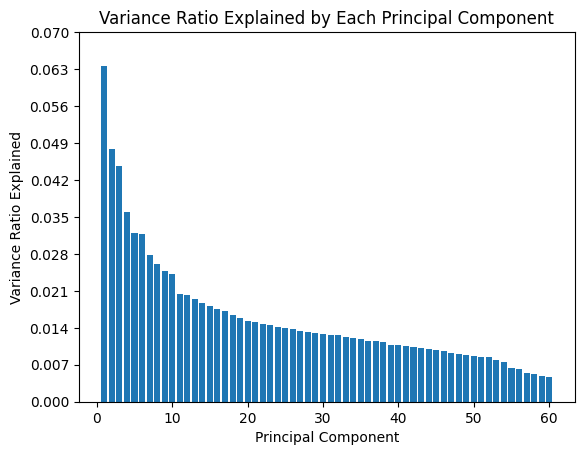

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4931 - accuracy: 0.8316
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3730 - accuracy: 0.8511
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3293 - accuracy: 0.8640
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3030 - accuracy: 0.8709
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2878 - accuracy: 0.8804
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2709 - accuracy: 0.8888
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2543 - accuracy: 0.8950
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2296 - accuracy: 0.9081
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2228 - accuracy: 0.9081
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


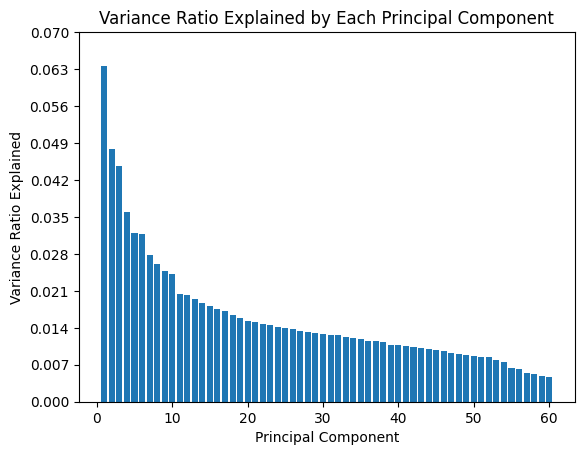

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4897 - accuracy: 0.8290
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3735 - accuracy: 0.8574
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3272 - accuracy: 0.8698
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3086 - accuracy: 0.8744
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2942 - accuracy: 0.8764
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2694 - accuracy: 0.8855
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2511 - accuracy: 0.8928
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2342 - accuracy: 0.9018
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2241 - accuracy: 0.9086
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


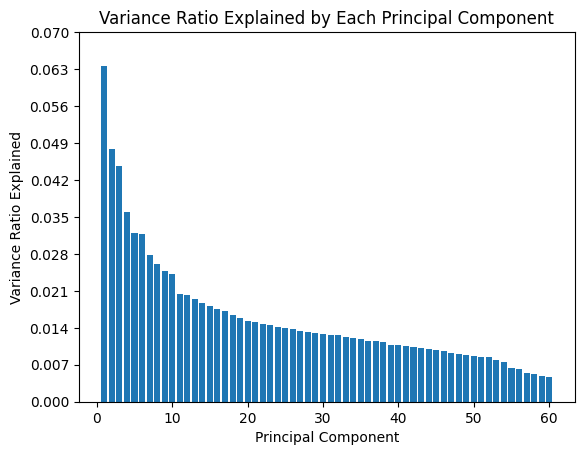

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4699 - accuracy: 0.8325
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3686 - accuracy: 0.8486
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3326 - accuracy: 0.8661
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3076 - accuracy: 0.8726
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2959 - accuracy: 0.8773
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2672 - accuracy: 0.8899
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2493 - accuracy: 0.8955
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2413 - accuracy: 0.8993
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2288 - accuracy: 0.9040
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


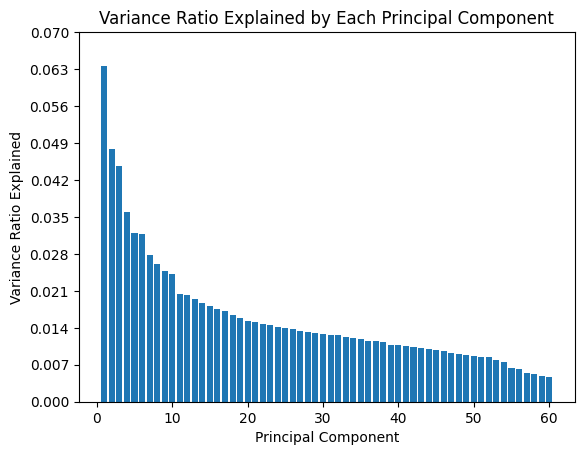

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4929 - accuracy: 0.8283
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3630 - accuracy: 0.8589
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3309 - accuracy: 0.8646
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3124 - accuracy: 0.8723
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2870 - accuracy: 0.8806
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2710 - accuracy: 0.8888
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2555 - accuracy: 0.8967
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2405 - accuracy: 0.8999
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2204 - accuracy: 0.9100
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


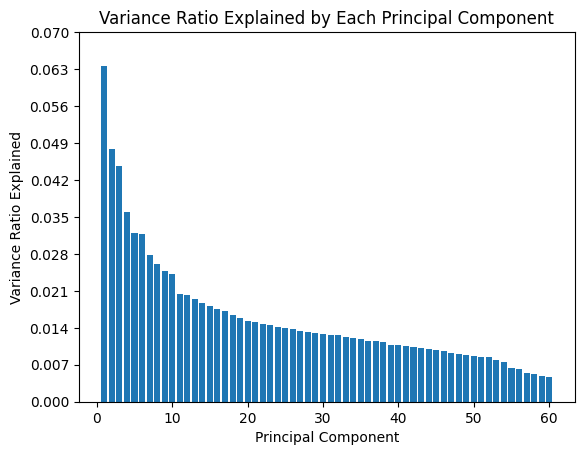

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4952 - accuracy: 0.8319
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3609 - accuracy: 0.8558
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3353 - accuracy: 0.8633
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3025 - accuracy: 0.8735
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2877 - accuracy: 0.8815
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2631 - accuracy: 0.8893
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2530 - accuracy: 0.8928
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2404 - accuracy: 0.9005
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2276 - accuracy: 0.9094
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


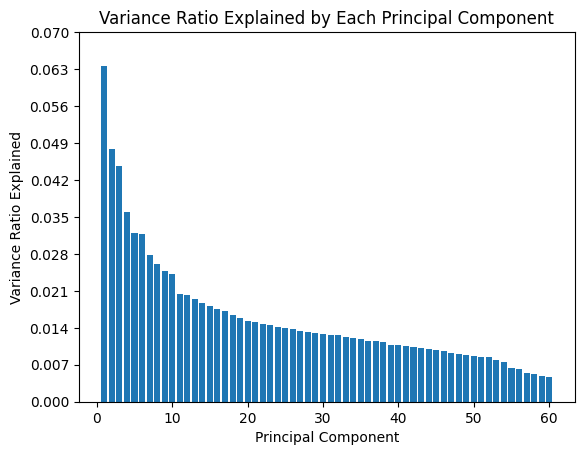

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4597 - accuracy: 0.8366
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3703 - accuracy: 0.8566
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3443 - accuracy: 0.8608
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3182 - accuracy: 0.8698
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2940 - accuracy: 0.8786
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2801 - accuracy: 0.8810
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2493 - accuracy: 0.8954
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2439 - accuracy: 0.8976
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2232 - accuracy: 0.9098
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


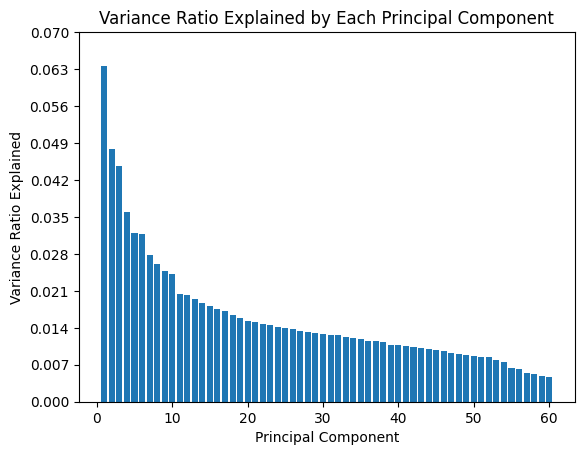

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4866 - accuracy: 0.8290
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3741 - accuracy: 0.8496
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3213 - accuracy: 0.8702
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.8734
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2929 - accuracy: 0.8782
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2679 - accuracy: 0.8877
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2525 - accuracy: 0.8942
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2361 - accuracy: 0.9039
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2244 - accuracy: 0.9081
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


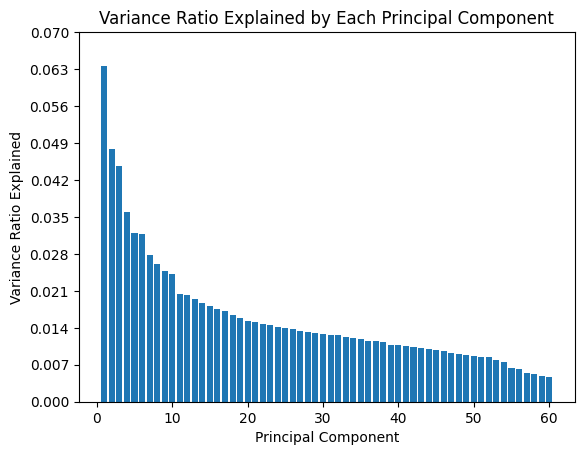

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4831 - accuracy: 0.8283
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3729 - accuracy: 0.8516
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3352 - accuracy: 0.8599
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3081 - accuracy: 0.8727
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2925 - accuracy: 0.8756
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2714 - accuracy: 0.8863
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2540 - accuracy: 0.8914
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2442 - accuracy: 0.8983
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2301 - accuracy: 0.9023
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


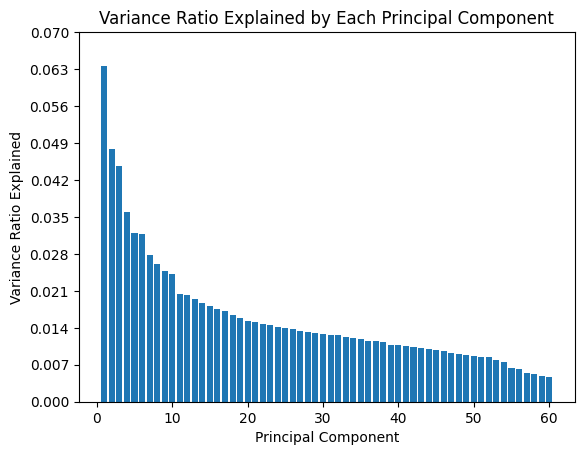

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4721 - accuracy: 0.8366
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3737 - accuracy: 0.8516
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3394 - accuracy: 0.8605
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3122 - accuracy: 0.8707
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2950 - accuracy: 0.8794
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2708 - accuracy: 0.8875
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2557 - accuracy: 0.8931
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2428 - accuracy: 0.8986
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2243 - accuracy: 0.9070
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


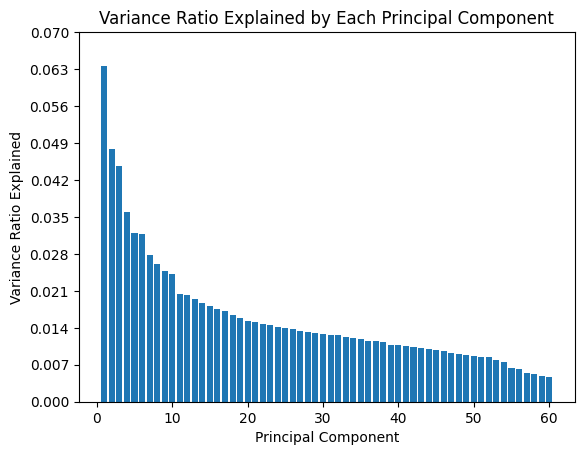

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4806 - accuracy: 0.8290
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3703 - accuracy: 0.8529
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3246 - accuracy: 0.8624
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3050 - accuracy: 0.8726
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2805 - accuracy: 0.8830
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2691 - accuracy: 0.8899
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2552 - accuracy: 0.8954
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2317 - accuracy: 0.9006
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2274 - accuracy: 0.9044
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [144]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(knn_df,NN_PCA_model)

In [145]:
print(f"basic_NN for Knn_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "PCA_knn_df"
df_results.loc[3] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for Knn_df : acc_ = 60.0, acc_2 =  nan, acc_3 = nan, std_1 = 3.710481478633001, std_2 = nan, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN
3,NN_basic,PCA_knn_df,60.000000,NaN,NaN,3.710481,NaN,NaN


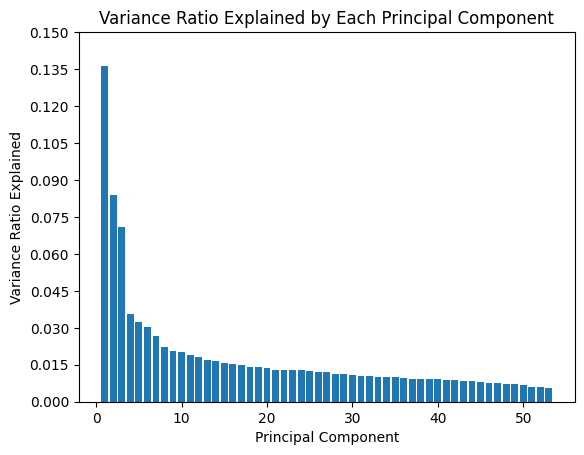

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4656 - accuracy: 0.8298
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3873 - accuracy: 0.8442
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3500 - accuracy: 0.8607
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3332 - accuracy: 0.8592
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3098 - accuracy: 0.8709
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2980 - accuracy: 0.8741
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2902 - accuracy: 0.8802
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2773 - accuracy: 0.8852
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2667 - accuracy: 0.8895
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


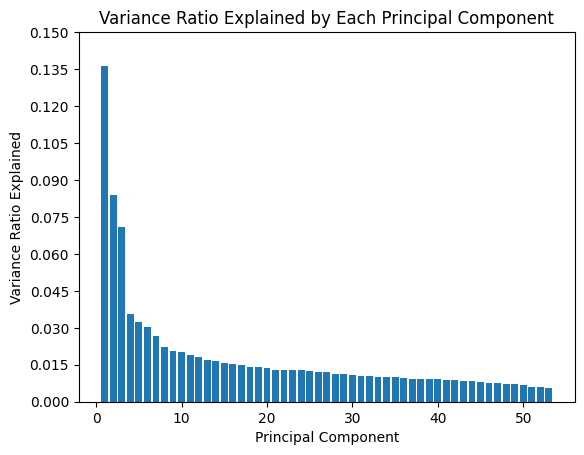

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4884 - accuracy: 0.8275
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3792 - accuracy: 0.8493
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3529 - accuracy: 0.8561
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3304 - accuracy: 0.8640
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3113 - accuracy: 0.8725
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3015 - accuracy: 0.8739
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2844 - accuracy: 0.8827
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2718 - accuracy: 0.8863
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2616 - accuracy: 0.8877
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


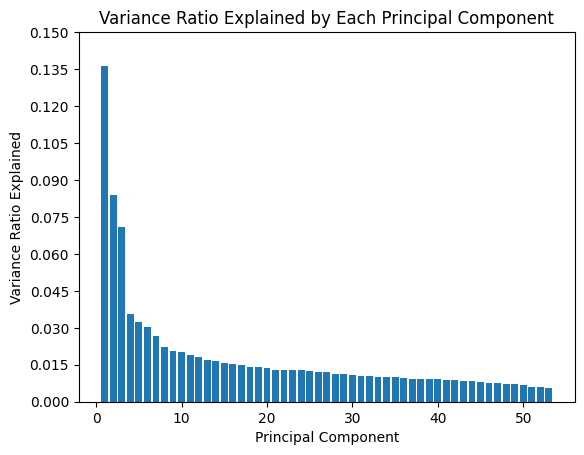

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4776 - accuracy: 0.8307
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3762 - accuracy: 0.8490
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3463 - accuracy: 0.8586
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3314 - accuracy: 0.8615
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3186 - accuracy: 0.8679
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3070 - accuracy: 0.8712
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2856 - accuracy: 0.8778
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2755 - accuracy: 0.8838
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2704 - accuracy: 0.8867
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


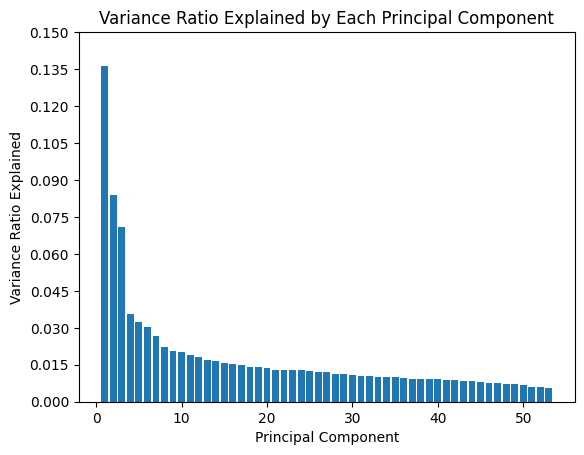

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4771 - accuracy: 0.8275
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3861 - accuracy: 0.8458
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3477 - accuracy: 0.8584
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3298 - accuracy: 0.8627
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3092 - accuracy: 0.8684
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2971 - accuracy: 0.8771
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2884 - accuracy: 0.8794
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2776 - accuracy: 0.8847
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2651 - accuracy: 0.8896
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


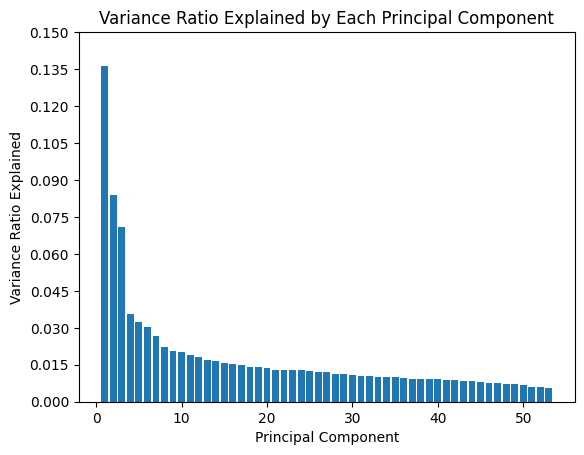

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4692 - accuracy: 0.8299
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3822 - accuracy: 0.8462
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3576 - accuracy: 0.8581
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3363 - accuracy: 0.8600
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3181 - accuracy: 0.8691
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3066 - accuracy: 0.8690
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2919 - accuracy: 0.8784
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2838 - accuracy: 0.8814
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2660 - accuracy: 0.8895
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


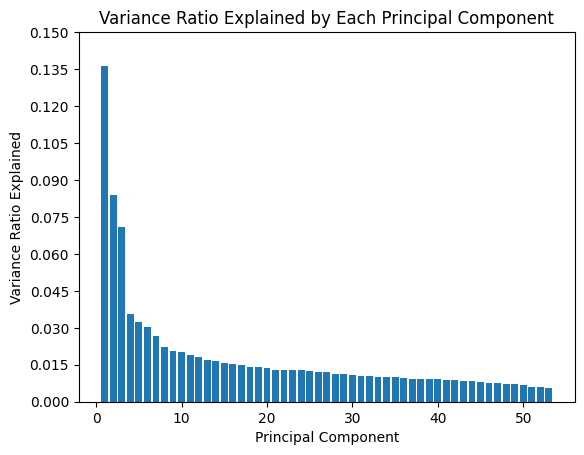

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4726 - accuracy: 0.8318
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3877 - accuracy: 0.8455
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3592 - accuracy: 0.8540
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3292 - accuracy: 0.8671
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3159 - accuracy: 0.8687
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2965 - accuracy: 0.8739
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2901 - accuracy: 0.8795
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2765 - accuracy: 0.8856
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2720 - accuracy: 0.8881
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


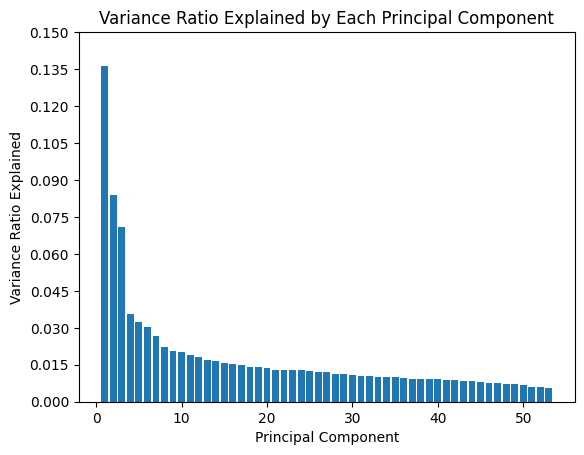

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4890 - accuracy: 0.8235
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.8479
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3446 - accuracy: 0.8558
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3264 - accuracy: 0.8645
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3118 - accuracy: 0.8689
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2979 - accuracy: 0.8755
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2885 - accuracy: 0.8825
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2739 - accuracy: 0.8857
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2663 - accuracy: 0.8847
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


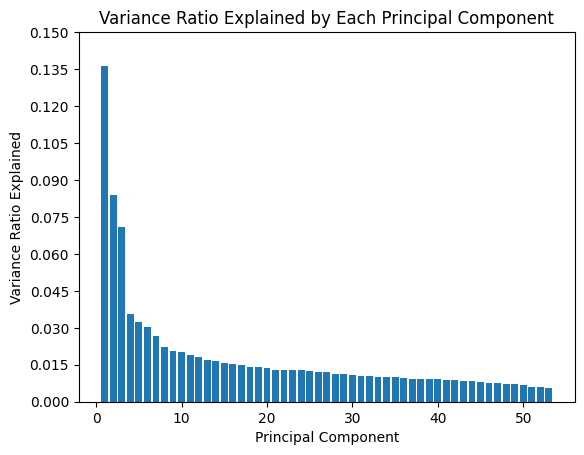

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4850 - accuracy: 0.8251
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3865 - accuracy: 0.8459
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3565 - accuracy: 0.8520
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3256 - accuracy: 0.8631
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3103 - accuracy: 0.8704
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3020 - accuracy: 0.8745
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2897 - accuracy: 0.8777
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2748 - accuracy: 0.8824
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2638 - accuracy: 0.8888
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


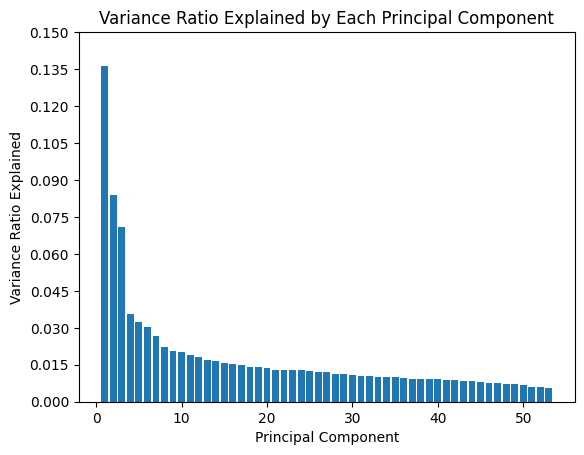

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4678 - accuracy: 0.8315
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3747 - accuracy: 0.8479
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3499 - accuracy: 0.8555
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3336 - accuracy: 0.8607
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3193 - accuracy: 0.8699
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2955 - accuracy: 0.8795
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2920 - accuracy: 0.8807
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2687 - accuracy: 0.8865
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2665 - accuracy: 0.8884
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


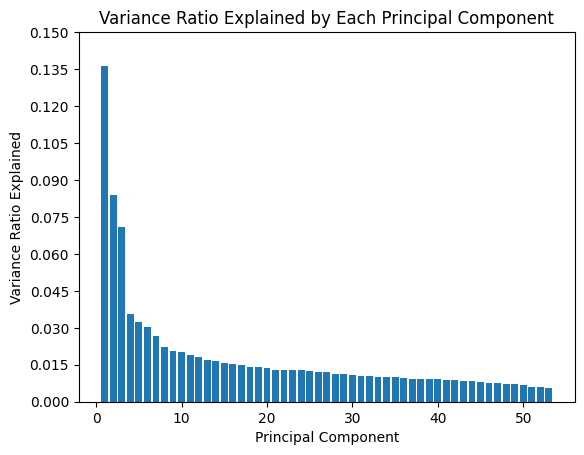

Number of components required to achieve 0.95 variance explained: 53
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.4803 - accuracy: 0.8271
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3776 - accuracy: 0.8510
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3558 - accuracy: 0.8541
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3303 - accuracy: 0.8645
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3167 - accuracy: 0.8673
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3053 - accuracy: 0.8698
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2855 - accuracy: 0.8800
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2752 - accuracy: 0.8852
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.2662 - accuracy: 0.8909
Epoch 10/20
300/300 [==========

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [146]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(m1_df,NN_PCA_model)

In [147]:
print(f"basic_NN for Knn_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "PCA_m1_df"
df_results.loc[4] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for Knn_df : acc_ = 63.23262839879153, acc_2 =  nan, acc_3 = nan, std_1 = 6.102494686432975, std_2 = nan, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN
3,NN_basic,PCA_knn_df,60.000000,NaN,NaN,3.710481,NaN,NaN
4,NN_basic,PCA_m1_df,63.232628,NaN,NaN,6.102495,NaN,NaN


**3.4 -Managing the inbalance problem.**

Balancing the initial dataframes with two different methods:

 - SOMTE
 - RandomOverSampler

In [148]:
def NN_Balanced_model(df, method):
    """
    Builds and trains an improved neural network model for binary classification with previous balanced strategy of the df.

    Args:
        Data frame.
        Method: balancing method to be applied to the Data frame

    Returns:
        Predicted value and real test value.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data balancing
    met = method(random_state=42)
    X_train, y_train = met.fit_resample(X_train, y_train)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_integer = np.argmax(y_pred, axis=1) + 1

    return y_test, y_pred_integer


as now we are using a function (NN_Balanced_model) that requiers an extra argument from run_10_times function we must use a labmda function to be able to pass this extra argument.

In [149]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, method=SMOTE))

Epoch 1/20
514/514 [==============================] - 2s 3ms/step - loss: 0.6219 - accuracy: 0.7678
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4008 - accuracy: 0.8363
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3159 - accuracy: 0.8710
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2633 - accuracy: 0.8930
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2294 - accuracy: 0.9094
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1883 - accuracy: 0.9270
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1772 - accuracy: 0.9318
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.9455
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1341 - accuracy: 0.9509
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1185 - accuracy: 0.9550

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 2s 3ms/step - loss: 0.6193 - accuracy: 0.7703
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4190 - accuracy: 0.8330
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3290 - accuracy: 0.8693
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2707 - accuracy: 0.8894
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2343 - accuracy: 0.9078
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1898 - accuracy: 0.9278
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1657 - accuracy: 0.9371
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1513 - accuracy: 0.9410
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1415 - accuracy: 0.9469
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1212 - accuracy: 0.9523

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 2ms/step - loss: 0.6321 - accuracy: 0.7716
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3975 - accuracy: 0.8396
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3275 - accuracy: 0.8714
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2653 - accuracy: 0.8967
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2193 - accuracy: 0.9129
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1950 - accuracy: 0.9234
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1672 - accuracy: 0.9360
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1495 - accuracy: 0.9418
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1413 - accuracy: 0.9481
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1265 - accuracy: 0.9512
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.6362 - accuracy: 0.7654
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3998 - accuracy: 0.8398
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3275 - accuracy: 0.8664
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2782 - accuracy: 0.8895
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2292 - accuracy: 0.9075
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1981 - accuracy: 0.9225
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1732 - accuracy: 0.9347
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1541 - accuracy: 0.9405
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1329 - accuracy: 0.9483
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1176 - accuracy: 0.9543
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 1s 2ms/step - loss: 0.6187 - accuracy: 0.7704
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4178 - accuracy: 0.8324
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3164 - accuracy: 0.8717
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2667 - accuracy: 0.8903
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2313 - accuracy: 0.9085
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1986 - accuracy: 0.9232
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1696 - accuracy: 0.9353
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1504 - accuracy: 0.9440
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1343 - accuracy: 0.9493
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1176 - accuracy: 0.9558

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 2ms/step - loss: 0.6370 - accuracy: 0.7705
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4006 - accuracy: 0.8377
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3089 - accuracy: 0.8709
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2667 - accuracy: 0.8929
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2234 - accuracy: 0.9116
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1919 - accuracy: 0.9259
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1651 - accuracy: 0.9362
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1399 - accuracy: 0.9443
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1366 - accuracy: 0.9487
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1243 - accuracy: 0.9549
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.6275 - accuracy: 0.7700
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3992 - accuracy: 0.8351
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3225 - accuracy: 0.8698
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2653 - accuracy: 0.8942
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2259 - accuracy: 0.9093
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1970 - accuracy: 0.9216
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1730 - accuracy: 0.9337
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1416 - accuracy: 0.9461
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1271 - accuracy: 0.9519
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1201 - accuracy: 0.9535
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.6127 - accuracy: 0.7776
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8405
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3193 - accuracy: 0.8714
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2762 - accuracy: 0.8889
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2272 - accuracy: 0.9104
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1921 - accuracy: 0.9255
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1689 - accuracy: 0.9342
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1538 - accuracy: 0.9411
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1356 - accuracy: 0.9495
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1221 - accuracy: 0.9541
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.6137 - accuracy: 0.7676
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4164 - accuracy: 0.8303
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3225 - accuracy: 0.8692
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2734 - accuracy: 0.8921
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2303 - accuracy: 0.9088
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1950 - accuracy: 0.9263
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1739 - accuracy: 0.9343
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1476 - accuracy: 0.9437
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1319 - accuracy: 0.9487
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1221 - accuracy: 0.9543
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.6355 - accuracy: 0.7642
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3913 - accuracy: 0.8397
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3252 - accuracy: 0.8697
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2653 - accuracy: 0.8942
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2282 - accuracy: 0.9089
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2011 - accuracy: 0.9208
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1723 - accuracy: 0.9356
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1464 - accuracy: 0.9445
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1355 - accuracy: 0.9497
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1137 - accuracy: 0.9570
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [150]:
print(f"basic_NN for Knn_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "Smote_knn_df"
df_results.loc[5] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for Knn_df : acc_ = 66.19335347432025, acc_2 =  nan, acc_3 = nan, std_1 = 2.532904280208238, std_2 = nan, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN
3,NN_basic,PCA_knn_df,60.000000,NaN,NaN,3.710481,NaN,NaN
4,NN_basic,PCA_m1_df,63.232628,NaN,NaN,6.102495,NaN,NaN
5,NN_basic,Smote_knn_df,66.193353,NaN,NaN,2.532904,NaN,NaN


In [151]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, method=SMOTE))

Epoch 1/20
514/514 [==============================] - 2s 2ms/step - loss: 0.6431 - accuracy: 0.7596
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4269 - accuracy: 0.8223
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3417 - accuracy: 0.8593
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2943 - accuracy: 0.8799
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2602 - accuracy: 0.8959
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2332 - accuracy: 0.9072
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1972 - accuracy: 0.9193
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1855 - accuracy: 0.9256
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1603 - accuracy: 0.9376
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1443 - accuracy: 0.9435

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 2s 3ms/step - loss: 0.6129 - accuracy: 0.7603
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4250 - accuracy: 0.8259
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3444 - accuracy: 0.8567
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2954 - accuracy: 0.8793
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2596 - accuracy: 0.8948
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2319 - accuracy: 0.9049
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2041 - accuracy: 0.9205
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1780 - accuracy: 0.9295
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1593 - accuracy: 0.9389
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1438 - accuracy: 0.9452

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 1s 2ms/step - loss: 0.6402 - accuracy: 0.7578
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4203 - accuracy: 0.8247
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3514 - accuracy: 0.8580
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2998 - accuracy: 0.8775
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2613 - accuracy: 0.8912
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2300 - accuracy: 0.9062
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1989 - accuracy: 0.9213
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1810 - accuracy: 0.9294
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1654 - accuracy: 0.9340
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1430 - accuracy: 0.9441

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.6536 - accuracy: 0.7527
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4182 - accuracy: 0.8244
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3493 - accuracy: 0.8546
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2970 - accuracy: 0.8759
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2618 - accuracy: 0.8913
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2331 - accuracy: 0.9053
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2035 - accuracy: 0.9184
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1773 - accuracy: 0.9294
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1640 - accuracy: 0.9354
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1485 - accuracy: 0.9415
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 2s 2ms/step - loss: 0.6418 - accuracy: 0.7574
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4284 - accuracy: 0.8225
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3517 - accuracy: 0.8534
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2947 - accuracy: 0.8774
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2666 - accuracy: 0.8924
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2274 - accuracy: 0.9085
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2009 - accuracy: 0.9188
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1852 - accuracy: 0.9279
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1638 - accuracy: 0.9344
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1552 - accuracy: 0.9373

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 2ms/step - loss: 0.6373 - accuracy: 0.7629
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4151 - accuracy: 0.8277
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3521 - accuracy: 0.8510
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3093 - accuracy: 0.8746
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2627 - accuracy: 0.8908
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2271 - accuracy: 0.9089
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1982 - accuracy: 0.9218
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1841 - accuracy: 0.9266
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1563 - accuracy: 0.9390
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1412 - accuracy: 0.9446
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.6291 - accuracy: 0.7583
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4439 - accuracy: 0.8192
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3506 - accuracy: 0.8564
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3020 - accuracy: 0.8740
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2641 - accuracy: 0.8913
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2311 - accuracy: 0.9083
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1981 - accuracy: 0.9221
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1834 - accuracy: 0.9292
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1582 - accuracy: 0.9362
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1532 - accuracy: 0.9411
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 1s 2ms/step - loss: 0.6322 - accuracy: 0.7608
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4282 - accuracy: 0.8200
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3433 - accuracy: 0.8580
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2992 - accuracy: 0.8795
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2642 - accuracy: 0.8914
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2253 - accuracy: 0.9106
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2005 - accuracy: 0.9187
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1797 - accuracy: 0.9280
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1525 - accuracy: 0.9401
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1474 - accuracy: 0.9415

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 1s 2ms/step - loss: 0.6354 - accuracy: 0.7639
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4189 - accuracy: 0.8230
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3555 - accuracy: 0.8512
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2960 - accuracy: 0.8748
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2658 - accuracy: 0.8907
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2284 - accuracy: 0.9085
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2103 - accuracy: 0.9149
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1848 - accuracy: 0.9241
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.9368
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1457 - accuracy: 0.9430

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 2s 2ms/step - loss: 0.6441 - accuracy: 0.7536
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4098 - accuracy: 0.8282
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3508 - accuracy: 0.8537
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2965 - accuracy: 0.8779
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2543 - accuracy: 0.8965
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2293 - accuracy: 0.9089
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1983 - accuracy: 0.9207
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1786 - accuracy: 0.9311
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1597 - accuracy: 0.9356
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1562 - accuracy: 0.9379

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [152]:
print(f"basic_NN for m1_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "Smote_m1_df"
df_results.loc[6] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for m1_df : acc_ = 65.5891238670695, acc_2 =  nan, acc_3 = nan, std_1 = 2.9645760761881017, std_2 = nan, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN
3,NN_basic,PCA_knn_df,60.000000,NaN,NaN,3.710481,NaN,NaN
4,NN_basic,PCA_m1_df,63.232628,NaN,NaN,6.102495,NaN,NaN
5,NN_basic,Smote_knn_df,66.193353,NaN,NaN,2.532904,NaN,NaN
6,NN_basic,Smote_m1_df,65.589124,NaN,NaN,2.964576,NaN,NaN


In [153]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, method=RandomOverSampler))

Epoch 1/20
514/514 [==============================] - 2s 2ms/step - loss: 0.7207 - accuracy: 0.7220
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4455 - accuracy: 0.8139
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3510 - accuracy: 0.8524
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2765 - accuracy: 0.8881
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2371 - accuracy: 0.9051
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1939 - accuracy: 0.9255
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1717 - accuracy: 0.9339
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1456 - accuracy: 0.9450
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1229 - accuracy: 0.9530
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1188 - accuracy: 0.9567

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.7064 - accuracy: 0.7299
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4439 - accuracy: 0.8123
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8536
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2896 - accuracy: 0.8817
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2341 - accuracy: 0.9052
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1984 - accuracy: 0.9221
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1693 - accuracy: 0.9366
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1496 - accuracy: 0.9444
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1325 - accuracy: 0.9497
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1048 - accuracy: 0.9596
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7333 - accuracy: 0.7228
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4515 - accuracy: 0.8107
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3560 - accuracy: 0.8512
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2828 - accuracy: 0.8830
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2458 - accuracy: 0.9042
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2031 - accuracy: 0.9187
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1675 - accuracy: 0.9342
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1534 - accuracy: 0.9410
Epoch 9/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1376 - accuracy: 0.9489
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1065 - accuracy: 0.9605
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 2ms/step - loss: 0.7266 - accuracy: 0.7257
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4396 - accuracy: 0.8135
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3577 - accuracy: 0.8520
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2837 - accuracy: 0.8847
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2408 - accuracy: 0.9056
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1960 - accuracy: 0.9245
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1655 - accuracy: 0.9373
Epoch 8/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1492 - accuracy: 0.9436
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1309 - accuracy: 0.9501
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1143 - accuracy: 0.9577
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 1s 2ms/step - loss: 0.7215 - accuracy: 0.7245
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4576 - accuracy: 0.8066
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3539 - accuracy: 0.8526
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2921 - accuracy: 0.8838
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2338 - accuracy: 0.9069
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2018 - accuracy: 0.9230
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1764 - accuracy: 0.9315
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1517 - accuracy: 0.9430
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy: 0.9529
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1122 - accuracy: 0.9576
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7152 - accuracy: 0.7289
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4453 - accuracy: 0.8086
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3492 - accuracy: 0.8567
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2806 - accuracy: 0.8854
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2246 - accuracy: 0.9102
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1995 - accuracy: 0.9215
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.9391
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1408 - accuracy: 0.9464
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1293 - accuracy: 0.9503
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1067 - accuracy: 0.9599
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 2ms/step - loss: 0.6995 - accuracy: 0.7278
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4543 - accuracy: 0.8095
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3535 - accuracy: 0.8547
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2866 - accuracy: 0.8801
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2374 - accuracy: 0.9066
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2006 - accuracy: 0.9231
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1578 - accuracy: 0.9392
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.9427
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1292 - accuracy: 0.9515
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1125 - accuracy: 0.9597
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 2ms/step - loss: 0.7203 - accuracy: 0.7257
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4510 - accuracy: 0.8071
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3552 - accuracy: 0.8537
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2800 - accuracy: 0.8853
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2379 - accuracy: 0.9055
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1984 - accuracy: 0.9220
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1750 - accuracy: 0.9358
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1465 - accuracy: 0.9434
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1416 - accuracy: 0.9470
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1131 - accuracy: 0.9593
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7023 - accuracy: 0.7291
Epoch 2/20
514/514 [==============================] - 2s 3ms/step - loss: 0.4537 - accuracy: 0.8071
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3525 - accuracy: 0.8547
Epoch 4/20
514/514 [==============================] - 2s 3ms/step - loss: 0.2893 - accuracy: 0.8859
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2303 - accuracy: 0.9099
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2063 - accuracy: 0.9187
Epoch 7/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1692 - accuracy: 0.9339
Epoch 8/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1457 - accuracy: 0.9442
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1331 - accuracy: 0.9506
Epoch 10/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1127 - accuracy: 0.9594
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7049 - accuracy: 0.7275
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4602 - accuracy: 0.8016
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3426 - accuracy: 0.8576
Epoch 4/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2902 - accuracy: 0.8842
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2419 - accuracy: 0.9028
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1980 - accuracy: 0.9219
Epoch 7/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1651 - accuracy: 0.9356
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1445 - accuracy: 0.9474
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1248 - accuracy: 0.9540
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1087 - accuracy: 0.9607
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [154]:
print(f"basic_NN for knn_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "ros_knn_df"
df_results.loc[7] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for knn_df : acc_ = 62.08459214501511, acc_2 =  nan, acc_3 = nan, std_1 = 2.9701127451919866, std_2 = nan, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN
3,NN_basic,PCA_knn_df,60.000000,NaN,NaN,3.710481,NaN,NaN
4,NN_basic,PCA_m1_df,63.232628,NaN,NaN,6.102495,NaN,NaN
5,NN_basic,Smote_knn_df,66.193353,NaN,NaN,2.532904,NaN,NaN
6,NN_basic,Smote_m1_df,65.589124,NaN,NaN,2.964576,NaN,NaN
7,NN_basic,ros_knn_df,62.084592,NaN,NaN,2.970113,NaN,NaN


In [155]:
acc_1, acc_2, acc_3, std_1, std_2, std_3 = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, method=RandomOverSampler))

Epoch 1/20
514/514 [==============================] - 2s 2ms/step - loss: 0.7208 - accuracy: 0.7149
Epoch 2/20
514/514 [==============================] - 1s 2ms/step - loss: 0.4886 - accuracy: 0.7871
Epoch 3/20
514/514 [==============================] - 1s 2ms/step - loss: 0.3955 - accuracy: 0.8301
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3347 - accuracy: 0.8580
Epoch 5/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2819 - accuracy: 0.8859
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2485 - accuracy: 0.9011
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2135 - accuracy: 0.9162
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1841 - accuracy: 0.9263
Epoch 9/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1586 - accuracy: 0.9383
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1572 - accuracy: 0.9405

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 2s 2ms/step - loss: 0.7294 - accuracy: 0.7108
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4830 - accuracy: 0.7880
Epoch 3/20
514/514 [==============================] - 2s 3ms/step - loss: 0.3899 - accuracy: 0.8320
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3390 - accuracy: 0.8580
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2846 - accuracy: 0.8832
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2436 - accuracy: 0.8999
Epoch 7/20
514/514 [==============================] - 2s 3ms/step - loss: 0.2146 - accuracy: 0.9156
Epoch 8/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1886 - accuracy: 0.9266
Epoch 9/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1603 - accuracy: 0.9373
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1520 - accuracy: 0.9413

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7419 - accuracy: 0.7113
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4913 - accuracy: 0.7840
Epoch 3/20
514/514 [==============================] - 2s 3ms/step - loss: 0.3934 - accuracy: 0.8293
Epoch 4/20
514/514 [==============================] - 2s 3ms/step - loss: 0.3235 - accuracy: 0.8652
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2833 - accuracy: 0.8860
Epoch 6/20
514/514 [==============================] - 2s 3ms/step - loss: 0.2487 - accuracy: 0.9031
Epoch 7/20
514/514 [==============================] - 2s 3ms/step - loss: 0.2215 - accuracy: 0.9124
Epoch 8/20
514/514 [==============================] - 2s 4ms/step - loss: 0.1933 - accuracy: 0.9241
Epoch 9/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1656 - accuracy: 0.9360
Epoch 10/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1400 - accuracy: 0.9462
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7363 - accuracy: 0.7149
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4852 - accuracy: 0.7879
Epoch 3/20
514/514 [==============================] - 2s 4ms/step - loss: 0.4023 - accuracy: 0.8248
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3409 - accuracy: 0.8560
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2822 - accuracy: 0.8844
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2519 - accuracy: 0.9007
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2151 - accuracy: 0.9147
Epoch 8/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1971 - accuracy: 0.9213
Epoch 9/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1660 - accuracy: 0.9371
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1438 - accuracy: 0.9449
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7279 - accuracy: 0.7136
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4910 - accuracy: 0.7862
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4007 - accuracy: 0.8244
Epoch 4/20
514/514 [==============================] - 2s 3ms/step - loss: 0.3343 - accuracy: 0.8596
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2904 - accuracy: 0.8793
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2402 - accuracy: 0.9040
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2147 - accuracy: 0.9156
Epoch 8/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1904 - accuracy: 0.9257
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1654 - accuracy: 0.9359
Epoch 10/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1532 - accuracy: 0.9432
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7321 - accuracy: 0.7139
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4815 - accuracy: 0.7864
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3922 - accuracy: 0.8287
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3336 - accuracy: 0.8567
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2795 - accuracy: 0.8887
Epoch 6/20
514/514 [==============================] - 1s 2ms/step - loss: 0.2429 - accuracy: 0.9013
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2115 - accuracy: 0.9180
Epoch 8/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1896 - accuracy: 0.9247
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.9373
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1447 - accuracy: 0.9433
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7248 - accuracy: 0.7149
Epoch 2/20
514/514 [==============================] - 2s 3ms/step - loss: 0.4996 - accuracy: 0.7814
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4032 - accuracy: 0.8253
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3332 - accuracy: 0.8585
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2923 - accuracy: 0.8816
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2500 - accuracy: 0.8959
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2145 - accuracy: 0.9150
Epoch 8/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1855 - accuracy: 0.9283
Epoch 9/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1662 - accuracy: 0.9391
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1454 - accuracy: 0.9440
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


514/514 [==============================] - 2s 3ms/step - loss: 0.7318 - accuracy: 0.7149
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4905 - accuracy: 0.7825
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3984 - accuracy: 0.8258
Epoch 4/20
514/514 [==============================] - 2s 3ms/step - loss: 0.3275 - accuracy: 0.8633
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2816 - accuracy: 0.8842
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2464 - accuracy: 0.9019
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2122 - accuracy: 0.9162
Epoch 8/20
514/514 [==============================] - 1s 2ms/step - loss: 0.1820 - accuracy: 0.9317
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.9346
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1561 - accuracy: 0.9393
Epoch 11/2

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 2s 3ms/step - loss: 0.7405 - accuracy: 0.7068
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4705 - accuracy: 0.7913
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3932 - accuracy: 0.8306
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3389 - accuracy: 0.8567
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2818 - accuracy: 0.8873
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2428 - accuracy: 0.9039
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2155 - accuracy: 0.9166
Epoch 8/20
514/514 [==============================] - 2s 3ms/step - loss: 0.1901 - accuracy: 0.9241
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.9376
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1468 - accuracy: 0.9431

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


Epoch 1/20
514/514 [==============================] - 2s 3ms/step - loss: 0.7214 - accuracy: 0.7139
Epoch 2/20
514/514 [==============================] - 1s 3ms/step - loss: 0.4848 - accuracy: 0.7891
Epoch 3/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3935 - accuracy: 0.8308
Epoch 4/20
514/514 [==============================] - 1s 3ms/step - loss: 0.3245 - accuracy: 0.8645
Epoch 5/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2786 - accuracy: 0.8867
Epoch 6/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2393 - accuracy: 0.9059
Epoch 7/20
514/514 [==============================] - 1s 3ms/step - loss: 0.2118 - accuracy: 0.9145
Epoch 8/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1877 - accuracy: 0.9273
Epoch 9/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1626 - accuracy: 0.9373
Epoch 10/20
514/514 [==============================] - 1s 3ms/step - loss: 0.1482 - accuracy: 0.9425

C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:16: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_2.append(correct_2 / total_2 * 100)
C:\Users\psaez\AppData\Local\Temp\ipykernel_3140\261996966.py:20: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_3.append(correct_3 / total_3 * 100)


In [156]:
print(f"basic_NN for m1_df : acc_ = {acc_1}, acc_2 =  {acc_2}, acc_3 = {acc_3}, std_1 = {std_1}, std_2 = {std_2}, std_3 = {std_3}")
#introducing the results in the df_results
Model = "NN_basic"
method_name = "ros_m1_df"
df_results.loc[8] = [Model, method_name, acc_1, acc_2, acc_3, std_1, std_2, std_3]
df_results

basic_NN for m1_df : acc_ = 60.81570996978852, acc_2 =  nan, acc_3 = nan, std_1 = 2.695602299540104, std_2 = nan, std_3 = nan


,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN
3,NN_basic,PCA_knn_df,60.000000,NaN,NaN,3.710481,NaN,NaN
4,NN_basic,PCA_m1_df,63.232628,NaN,NaN,6.102495,NaN,NaN
5,NN_basic,Smote_knn_df,66.193353,NaN,NaN,2.532904,NaN,NaN
6,NN_basic,Smote_m1_df,65.589124,NaN,NaN,2.964576,NaN,NaN
7,NN_basic,ros_knn_df,62.084592,NaN,NaN,2.970113,NaN,NaN
8,NN_basic,ros_m1_df,60.815710,NaN,NaN,2.695602,NaN,NaN


In [157]:
df_results_stay= df_results

In [158]:
df_results_stay

,Model,Method,mean_acc_1 (%),mean_acc_2 (%),mean_acc_3 (%),std_acc_1,std_acc_2,std_acc_3
0,Random_ev,Random_ev,35.250000,57.370000,7.38,0.000000,0.000000,0.0
1,NN_basic,knn_df,27.066667,72.267442,NaN,3.133465,4.200959,NaN
2,NN_basic,m1,27.066667,72.267442,NaN,3.133465,4.200959,NaN
3,NN_basic,PCA_knn_df,60.000000,NaN,NaN,3.710481,NaN,NaN
4,NN_basic,PCA_m1_df,63.232628,NaN,NaN,6.102495,NaN,NaN
5,NN_basic,Smote_knn_df,66.193353,NaN,NaN,2.532904,NaN,NaN
6,NN_basic,Smote_m1_df,65.589124,NaN,NaN,2.964576,NaN,NaN
7,NN_basic,ros_knn_df,62.084592,NaN,NaN,2.970113,NaN,NaN
8,NN_basic,ros_m1_df,60.815710,NaN,NaN,2.695602,NaN,NaN


#### let's see if just whith some very specific features we can predict better:
 - Age	
 - Gender	
 - ICUType

In [161]:
df_stay_prediction = knn_df[['Age',	'Gender',	'ICUType', 'Length_of_stay']]

In [163]:
#LogisticRegression

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load your dataframe
df_stay_prediction = knn_df[['Age', 'Gender', 'ICUType', 'Length_of_stay']]

# Split features and target variable
X = df_stay_prediction[['Age', 'Gender', 'ICUType']]
y = df_stay_prediction['Length_of_stay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000, multi_class='auto')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy for each class
accuracy_0 = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
accuracy_1 = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
accuracy_2 = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

# Print results
print("Accuracy for Length_of_stay == 0:", accuracy_0)
print("Accuracy for Length_of_stay == 1:", accuracy_1)
print("Accuracy for Length_of_stay == 2:", accuracy_2)


Accuracy for Length_of_stay == 0: 0.04669703872437358
Accuracy for Length_of_stay == 1: 0.977037037037037
Accuracy for Length_of_stay == 2: 0.0


In [8]:
#KNeighborsClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load your dataframe
df_stay_prediction = knn_df[['Age', 'Gender', 'ICUType', 'Length_of_stay']]

# Split features and target variable
X = df_stay_prediction[['Age', 'Gender', 'ICUType']]
y = df_stay_prediction['Length_of_stay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the KNN model
k = 5  # Number of neighbors
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy for each class
accuracy_0 = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
accuracy_1 = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
accuracy_2 = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

# Print results
print("Accuracy for Length_of_stay == 0:", accuracy_0)
print("Accuracy for Length_of_stay == 1:", accuracy_1)
print("Accuracy for Length_of_stay == 2:", accuracy_2)


Accuracy for Length_of_stay == 0: nan
Accuracy for Length_of_stay == 1: 0.0
Accuracy for Length_of_stay == 2: 0.02702702702702703


c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [166]:
#RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and target variable
X = df_stay_prediction.drop(columns=['Length_of_stay'])
y = df_stay_prediction['Length_of_stay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the length of stay
y_pred = rf_classifier.predict(X_test)

accuracy_0 = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
accuracy_1 = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
accuracy_2 = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

print("Accuracy for length of stay 0:", accuracy_0)
print("Accuracy for length of stay 1:", accuracy_1)
print("Accuracy for length of stay 2:", accuracy_2)

Accuracy for length of stay 0: 0.19248291571753987
Accuracy for length of stay 1: 0.8622222222222222
Accuracy for length of stay 2: 0.0


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Load your dataframe
df_stay_prediction = knn_df[['Age', 'Gender', 'ICUType', 'Length_of_stay']]

# Split features and target variable
X = df_stay_prediction[['Age', 'Gender', 'ICUType']]
y = df_stay_prediction['Length_of_stay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the K-means clustering model
k = 3  # Number of clusters (0, 1, 2)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

# Make predictions on the test set
y_pred_train = kmeans.predict(X_train)
y_pred_test = kmeans.predict(X_test)

# Calculate accuracy for each cluster
accuracy_0_train = accuracy_score(y_train[y_train == 0], y_pred_train[y_train == 0])
accuracy_1_train = accuracy_score(y_train[y_train == 1], y_pred_train[y_train == 1])
accuracy_2_train = accuracy_score(y_train[y_train == 2], y_pred_train[y_train == 2])

accuracy_0_test = accuracy_score(y_test[y_test == 0], y_pred_test[y_test == 0])
accuracy_1_test = accuracy_score(y_test[y_test == 1], y_pred_test[y_test == 1])
accuracy_2_test = accuracy_score(y_test[y_test == 2], y_pred_test[y_test == 2])

# Print results
print("Train Accuracy for Length_of_stay == 0:", accuracy_0_train)
print("Train Accuracy for Length_of_stay == 1:", accuracy_1_train)
print("Train Accuracy for Length_of_stay == 2:", accuracy_2_train)

print("Test Accuracy for Length_of_stay == 0:", accuracy_0_test)
print("Test Accuracy for Length_of_stay == 1:", accuracy_1_test)
print("Test Accuracy for Length_of_stay == 2:", accuracy_2_test)


Train Accuracy for Length_of_stay == 0: nan
Train Accuracy for Length_of_stay == 1: 0.25
Train Accuracy for Length_of_stay == 2: 0.22142857142857142
Test Accuracy for Length_of_stay == 0: nan
Test Accuracy for Length_of_stay == 1: 0.0
Test Accuracy for Length_of_stay == 2: 0.2702702702702703


c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# Load your dataframe
df_stay_prediction = knn_df[['Age', 'Gender', 'ICUType', 'Length_of_stay']]

# Split features and target variable
X = df_stay_prediction[['Age', 'Gender', 'ICUType']]
y = df_stay_prediction['Length_of_stay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Gaussian Mixture Model
n_components = 3  # Number of components (clusters)
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_train)

# Make predictions on the test set
y_pred_train = gmm.predict(X_train)
y_pred_test = gmm.predict(X_test)

# Calculate accuracy for each cluster
accuracy_0_train = accuracy_score(y_train[y_train == 0], y_pred_train[y_train == 0])
accuracy_1_train = accuracy_score(y_train[y_train == 1], y_pred_train[y_train == 1])
accuracy_2_train = accuracy_score(y_train[y_train == 2], y_pred_train[y_train == 2])

accuracy_0_test = accuracy_score(y_test[y_test == 0], y_pred_test[y_test == 0])
accuracy_1_test = accuracy_score(y_test[y_test == 1], y_pred_test[y_test == 1])
accuracy_2_test = accuracy_score(y_test[y_test == 2], y_pred_test[y_test == 2])

# Print results
print("Train Accuracy for Length_of_stay == 0:", accuracy_0_train)
print("Train Accuracy for Length_of_stay == 1:", accuracy_1_train)
print("Train Accuracy for Length_of_stay == 2:", accuracy_2_train)

print("Test Accuracy for Length_of_stay == 0:", accuracy_0_test)
print("Test Accuracy for Length_of_stay == 1:", accuracy_1_test)
print("Test Accuracy for Length_of_stay == 2:", accuracy_2_test)


Train Accuracy for Length_of_stay == 0: nan
Train Accuracy for Length_of_stay == 1: 0.25
Train Accuracy for Length_of_stay == 2: 0.3
Test Accuracy for Length_of_stay == 0: nan
Test Accuracy for Length_of_stay == 1: 0.0
Test Accuracy for Length_of_stay == 2: 0.2972972972972973


c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score

# Load your dataframe
df_stay_prediction = knn_df[['Age', 'Gender', 'ICUType', 'Length_of_stay']]

# Split features and target variable
X = df_stay_prediction[['Age', 'Gender', 'ICUType']]
y = df_stay_prediction['Length_of_stay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the DBSCAN model
eps = 0.3  # Maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 5  # Minimum number of samples in a neighborhood for a data point to be considered as a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_train)

# Make predictions on the test set
y_pred_train = dbscan.labels_
y_pred_test = dbscan.fit_predict(X_test)

# Calculate accuracy for each cluster
accuracy_0_train = accuracy_score(y_train[y_train == 0], y_pred_train[y_train == 0])
accuracy_1_train = accuracy_score(y_train[y_train == 1], y_pred_train[y_train == 1])
accuracy_2_train = accuracy_score(y_train[y_train == 2], y_pred_train[y_train == 2])

accuracy_0_test = accuracy_score(y_test[y_test == 0], y_pred_test[y_test == 0])
accuracy_1_test = accuracy_score(y_test[y_test == 1], y_pred_test[y_test == 1])
accuracy_2_test = accuracy_score(y_test[y_test == 2], y_pred_test[y_test == 2])

# Print results
print("Train Accuracy for Length_of_stay == 0:", accuracy_0_train)
print("Train Accuracy for Length_of_stay == 1:", accuracy_1_train)
print("Train Accuracy for Length_of_stay == 2:", accuracy_2_train)

print("Test Accuracy for Length_of_stay == 0:", accuracy_0_test)
print("Test Accuracy for Length_of_stay == 1:", accuracy_1_test)
print("Test Accuracy for Length_of_stay == 2:", accuracy_2_test)


Train Accuracy for Length_of_stay == 0: nan
Train Accuracy for Length_of_stay == 1: 0.0
Train Accuracy for Length_of_stay == 2: 0.0
Test Accuracy for Length_of_stay == 0: nan
Test Accuracy for Length_of_stay == 1: 0.0
Test Accuracy for Length_of_stay == 2: 0.02702702702702703


c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
